In [1322]:
import torch
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

import pickle
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

#import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [1323]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [1324]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_complete.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_complete.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
# df_train = df_train.drop(columns="Unnamed: 0")
# df_labels = df_labels.drop(columns="Unnamed: 0")

In [1325]:
df_train 

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [1326]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [1327]:
column_to_number = {
    'BP1': 1,
    'BP2': 2,
    'BP3': 3,
    'BP4': 4,
    'BP5': 5,
    'BP6': 6,
    'BP7': 7,
    'BV1': 8
}

df_labels['anomaly_location'] = 0

for index, row in df_labels.iterrows():
    for col in column_to_number.keys():
        if row[col] == 1:
            df_labels.at[index, 'anomaly_location'] = column_to_number[col]
            break  

# df_labels = df_labels[153:]

In [1328]:
idx = df_labels["index"].values

In [1329]:
idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176])

In [1330]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [1331]:
df_train = df_train.loc[idx]

In [1332]:
df_train = df_train.drop(columns="index")

In [1333]:
df_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,0.878385,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,0.876131,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,0.871002,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,0.865435,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,0.863301,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,0.756802,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,0.795453,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,0.326300,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,0.277997,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [1334]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [1335]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [1336]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [1337]:
# df_labels = df_labels[154:]
# df_train = df_train[154:]

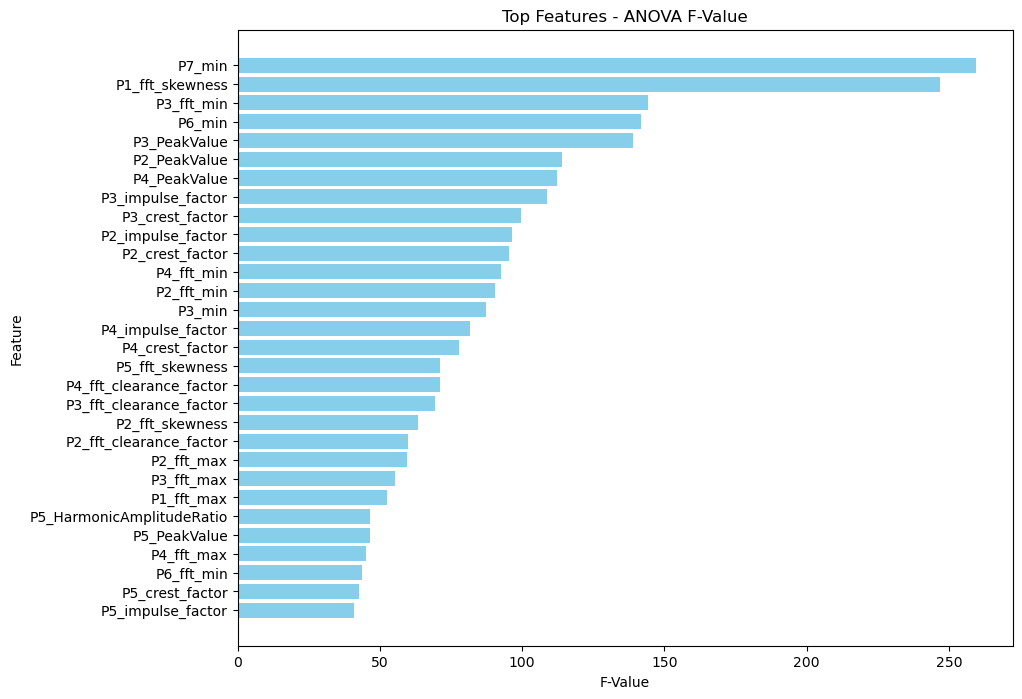

In [1338]:
features_chi2_train = feature_selection_anova(df_train,df_labels["anomaly_location"],30)


In [1339]:
df_train = df_train[features_chi2_train]
df_test = df_test[features_chi2_train]



In [1340]:
df_train = df_train[features_chi2_train]


In [1341]:
df_train

,P7_min,P1_fft_skewness,P3_fft_min,P6_min,P3_PeakValue,P2_PeakValue,P4_PeakValue,P3_impulse_factor,P3_crest_factor,P2_impulse_factor,...,P2_fft_clearance_factor,P2_fft_max,P3_fft_max,P1_fft_max,P5_HarmonicAmplitudeRatio,P5_PeakValue,P4_fft_max,P6_fft_min,P5_crest_factor,P5_impulse_factor
0,0.058956,0.387633,0.562991,0.097434,0.341638,0.412707,0.265903,0.443103,0.448061,0.508484,...,0.528569,0.589486,0.555061,0.646085,0.404716,0.534438,0.621318,0.348099,0.604552,0.609164
1,0.056874,0.385014,0.563282,0.096689,0.336818,0.411415,0.262757,0.437951,0.442880,0.507329,...,0.524562,0.584120,0.550394,0.640009,0.386983,0.512191,0.616919,0.352546,0.582898,0.587165
2,0.047910,0.380942,0.568247,0.096679,0.331412,0.411035,0.257358,0.432501,0.437274,0.506712,...,0.520386,0.577695,0.545137,0.632649,0.385712,0.496858,0.609333,0.346542,0.568830,0.572596
3,0.060588,0.377372,0.570982,0.097470,0.325390,0.408649,0.253298,0.426036,0.430810,0.504255,...,0.516512,0.573495,0.539248,0.626942,0.384052,0.502617,0.603600,0.344251,0.574005,0.578185
4,0.060022,0.375677,0.570573,0.096561,0.321175,0.406204,0.250622,0.421352,0.426236,0.501967,...,0.512699,0.569448,0.535108,0.623305,0.382267,0.504545,0.599806,0.348510,0.575556,0.579944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.068167,0.470502,0.072778,0.068792,0.897040,1.000000,1.000000,0.928283,0.922634,1.000000,...,0.884560,0.738037,0.684572,0.738090,1.000000,0.958063,0.916668,0.000000,0.975993,0.968190
173,0.026051,0.919978,0.506180,0.103085,0.377908,0.464207,0.287017,0.479462,0.480306,0.558606,...,0.589115,0.686053,0.570612,0.848741,0.697196,0.887110,0.650453,0.287958,0.912180,0.911152
174,0.071735,0.609891,0.707586,0.774105,0.191449,0.226731,0.178887,0.271971,0.272476,0.308189,...,0.156985,0.162392,0.123939,0.214549,0.438246,0.335453,0.236346,0.260383,0.412224,0.410221
175,0.777969,0.798344,1.000000,0.126092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.176845,0.148986,0.251210,0.000000,0.000000,0.169138,1.000000,0.000000,0.000000


In [1342]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,anomaly_location
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1,4
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1,5
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1,6
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7


In [1343]:

num_locations = df_labels["anomaly_location"].unique()
num_locations = sorted(num_locations)
print(num_locations)

X_train, X_test, y_train, y_test = train_test_split(df_train, df_labels["anomaly_location"], test_size=0.1,random_state=123)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [1344]:
y_test

133    0
134    0
130    0
163    3
173    5
60     0
41     0
146    0
125    0
143    0
160    8
127    0
72     0
33     0
31     0
151    0
142    0
165    5
Name: anomaly_location, dtype: int64

In [1345]:
y_train

42     0
157    5
138    0
144    0
100    0
      ..
17     0
98     0
66     0
126    0
109    0
Name: anomaly_location, Length: 159, dtype: int64

In [1346]:
confusion_matrices = []


models = []


for location in num_locations:

    y_binary_train = y_train == location
    
    model = RandomForestClassifier(random_state=123)
    model.fit(X_train, y_binary_train)
    
    models.append([model,location])
    
    y_pred_binary = model.predict(X_test)
    
    cm = confusion_matrix(y_binary_train, model.predict(X_train))
    confusion_matrices.append(cm)

  
predictions = []
for model in models:
    rf_model = model[0]
    pred = rf_model.predict(X_test)
    predictions.append(pred)




In [1347]:
with open(f'{path_dataframes}/index_test_anomaly_task2.pkl', 'rb') as file:
    anomaly_idx = pickle.load(file)


In [1348]:
anomaly_idx

array([178, 186, 193, 196, 197, 204, 209, 216, 219, 221])

In [1349]:
new_index_values = range(178, 224)
df_test.reset_index(drop=True, inplace=True)
df_test.index = new_index_values

In [1350]:
df_test = df_test.loc[anomaly_idx]

In [1351]:
print(models)

[[RandomForestClassifier(random_state=123), 0], [RandomForestClassifier(random_state=123), 1], [RandomForestClassifier(random_state=123), 2], [RandomForestClassifier(random_state=123), 3], [RandomForestClassifier(random_state=123), 4], [RandomForestClassifier(random_state=123), 5], [RandomForestClassifier(random_state=123), 6], [RandomForestClassifier(random_state=123), 7], [RandomForestClassifier(random_state=123), 8]]


In [1352]:
predictions = []
for model in models:
    print(model)
    rf_model = model[0]
    pred = rf_model.predict(df_test)
    predictions.append(pred)

[RandomForestClassifier(random_state=123), 0]
[RandomForestClassifier(random_state=123), 1]
[RandomForestClassifier(random_state=123), 2]
[RandomForestClassifier(random_state=123), 3]
[RandomForestClassifier(random_state=123), 4]
[RandomForestClassifier(random_state=123), 5]
[RandomForestClassifier(random_state=123), 6]
[RandomForestClassifier(random_state=123), 7]
[RandomForestClassifier(random_state=123), 8]


In [1353]:
true_indices = [np.where(arr)[0] for arr in predictions]
true_indices

[array([], dtype=int64),
 array([2]),
 array([0, 9]),
 array([5]),
 array([3]),
 array([8]),
 array([1]),
 array([4, 6]),
 array([], dtype=int64)]

In [1354]:
predictions


[array([False, False, False, False, False, False, False, False, False,
        False]),
 array([False, False,  True, False, False, False, False, False, False,
        False]),
 array([ True, False, False, False, False, False, False, False, False,
         True]),
 array([False, False, False, False, False,  True, False, False, False,
        False]),
 array([False, False, False,  True, False, False, False, False, False,
        False]),
 array([False, False, False, False, False, False, False, False,  True,
        False]),
 array([False,  True, False, False, False, False, False, False, False,
        False]),
 array([False, False, False, False,  True, False,  True, False, False,
        False]),
 array([False, False, False, False, False, False, False, False, False,
        False])]

In [1355]:
df_test

,P7_min,P1_fft_skewness,P3_fft_min,P6_min,P3_PeakValue,P2_PeakValue,P4_PeakValue,P3_impulse_factor,P3_crest_factor,P2_impulse_factor,...,P2_fft_clearance_factor,P2_fft_max,P3_fft_max,P1_fft_max,P5_HarmonicAmplitudeRatio,P5_PeakValue,P4_fft_max,P6_fft_min,P5_crest_factor,P5_impulse_factor
178,0.057270,0.722514,0.401928,0.072907,0.488078,0.613796,0.457453,0.587639,0.592712,0.694566,...,0.720227,0.737313,0.637245,0.774266,0.529602,0.615009,0.634096,0.205195,0.683546,0.682942
186,0.061998,0.496104,0.611917,0.980474,0.275684,0.328682,0.205421,0.371222,0.379218,0.421772,...,0.230587,0.182582,0.143612,0.255657,0.621510,0.564246,0.173561,0.012863,0.635212,0.635719
193,0.068587,0.079989,0.489325,0.107328,0.395089,0.473310,0.293553,0.498087,0.505241,0.568025,...,0.203561,0.012628,0.019415,0.004264,0.851832,0.560014,0.000000,0.218068,0.630216,0.631161
196,0.097949,0.590508,0.226858,0.106036,0.694040,0.795143,0.789699,0.767791,0.771019,0.845457,...,0.708034,0.587008,0.520251,0.587350,0.800488,0.788008,0.746879,0.065638,0.837720,0.832320
197,1.000823,0.720613,0.809769,0.409485,0.110142,0.149578,0.077323,0.166960,0.172961,0.214358,...,0.137176,0.212479,0.194325,0.318956,0.263327,0.248147,0.215546,0.603581,0.312930,0.315149
204,0.055155,0.908242,0.082525,0.103295,0.883596,0.850697,0.620886,0.915017,0.914113,0.887325,...,0.939457,0.972832,0.977121,0.963276,0.664471,0.783677,0.969887,0.089712,0.833661,0.829362
209,0.908434,0.823622,0.955817,0.412906,0.037774,0.018872,0.032056,0.061255,0.061232,0.030153,...,0.041456,0.217753,0.205006,0.302783,0.052288,0.056770,0.236108,0.917889,0.078338,0.079898
216,0.064078,0.138205,0.479814,0.107109,0.404891,0.478562,0.342764,0.507735,0.508973,0.572799,...,0.206547,0.013124,0.030465,0.060762,0.859325,0.546565,0.003859,0.224787,0.618682,0.618903
219,0.052109,1.005322,0.516495,0.409472,0.434519,0.544825,0.339267,0.537939,0.538100,0.633086,...,0.627796,0.751319,0.641362,0.934795,0.789116,1.015591,0.719870,0.262258,1.012403,1.012558
221,0.055382,0.839558,0.394397,0.071189,0.559459,0.677544,0.525820,0.654108,0.654130,0.749338,...,0.795700,0.851907,0.748290,0.900808,0.547354,0.663039,0.769994,0.212351,0.727488,0.726177
